In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [72]:
def psnr1(ground_truth, image): # 전체 channel 통합으로 PSNR 구하는 방법
    error = np.mean((ground_truth - image) ** 2)
    return 10*np.log10((255*255) / error)

In [73]:
def psnr2(ground_truth, image): # 각 Channel 별로 PSNR 구하는 방법
    psnrs = []
    for i in range(3):
        error = np.mean((ground_truth[:, :, i] - image[:, :, i]) ** 2)
        psnr = 10 * np.log10((255 * 255) / error)
        psnrs.append(psnr)
    return psnrs

In [74]:
def nearest_neighbor(image): 
    newR = np.zeros((256, 256), dtype=int)
    newG = np.zeros((256, 256), dtype=int)
    newB = np.zeros((256, 256), dtype=int)

    for i in range(64):
        for j in range(64):
            newR[4*i : 4*i+4, 4*j : 4*j+4] = image[i, j, 0]
            newG[4*i : 4*i+4, 4*j : 4*j+4] = image[i, j, 1]
            newB[4*i : 4*i+4, 4*j : 4*j+4] = image[i, j, 2]

    return np.stack([newR, newG, newB], axis=-1)

In [75]:
def bilinear(image):
    image = image.astype(np.float32)
    
    newR = np.zeros((256, 256), dtype=np.float32)
    newG = np.zeros((256, 256), dtype=np.float32)
    newB = np.zeros((256, 256), dtype=np.float32)
    
    for i in range(256):
        for j in range(256):
            # 실제 대응되는 위치
            p_ = i / 4
            q_ = j / 4
            # Down sampling image에서 대응되는 위치 - 내림 이용
            p = int(np.floor(p_))
            q = int(np.floor(q_))

            # Out of index 방지
            if (p >= 63): p = 62
            if (q >= 63): q = 62
            
            a = p_ - p
            b = q_ - q
            
            newR[i][j] = (1-a)*((1-b)*image[p][q][0] + b*image[p][q+1][0]) + a*((1-b)*image[p+1][q][0] + b*image[p+1][q+1][0])
            newG[i][j] = (1-a)*((1-b)*image[p][q][1] + b*image[p][q+1][1]) + a*((1-b)*image[p+1][q][1] + b*image[p+1][q+1][1])
            newB[i][j] = (1-a)*((1-b)*image[p][q][2] + b*image[p][q+1][2]) + a*((1-b)*image[p+1][q][2] + b*image[p+1][q+1][2])
    
    newR = newR.astype(np.uint8)
    newG = newG.astype(np.uint8)
    newB = newB.astype(np.uint8)
    
    return np.stack([newR, newG, newB], axis=-1)

In [76]:
def bicubic(image):
    image = image.astype(np.float32)
    
    newR = np.zeros((256, 256), dtype=np.float32)
    newG = np.zeros((256, 256), dtype=np.float32)
    newB = np.zeros((256, 256), dtype=np.float32)
    
    for i in range(8, 248):
        for j in range(8, 248):
            # 초기화
            r = g = b = 0.0
            
            # 실제 대응되는 위치
            p_ = i / 4
            q_ = j / 4
            
            # Down sampling image에서 대응되는 위치 - 내림 이용
            p = int(np.floor(p_))
            q = int(np.floor(q_))
            
            a = p_ - p
            b_ = q_ - q
            
            for m in range(-1, 3):
                for n in range(-1, 3):
                    w = R_c(m - a) * R_c(-n + b_)
                    r += image[p + m][q + n][0] * w
                    g += image[p + m][q + n][1] * w
                    b += image[p + m][q + n][2] * w

            newR[i][j] = r
            newG[i][j] = g
            newB[i][j] = b


    # padding
    newR[0:8, :] = newR[8:9, :]
    newR[248:, :] = newR[247:248, :]
    newR[:, 0:8] = newR[:, 8:9]
    newR[:, 248:] = newR[:, 247:248]

    newG[0:8, :] = newG[8:9, :]
    newG[248:, :] = newG[247:248, :]
    newG[:, 0:8] = newG[:, 8:9]
    newG[:, 248:] = newG[:, 247:248]

    newB[0:8, :] = newB[8:9, :]
    newB[248:, :] = newB[247:248, :]
    newB[:, 0:8] = newB[:, 8:9]
    newB[:, 248:] = newB[:, 247:248]

    
    newR = np.clip(newR, 0, 255).astype(np.uint8)
    newG = np.clip(newG, 0, 255).astype(np.uint8)
    newB = np.clip(newB, 0, 255).astype(np.uint8)
    
    result = np.stack([newR, newG, newB], axis=-1)
    
    return result


In [77]:
def cube(z):
    z = float(z)
    if (z > 0):
        return z ** 3
    else:
        return 0.0

In [78]:
def R_c(x):
    x = float(x)
    if x > 2 or x < -2:
        return 0.0
    
    result = (1 / 6) * (cube(x + 2) - 4 * cube(x + 1) + 6 * cube(x)- 4 * cube(x - 1))
    return round(result, 6) # overflow 방지


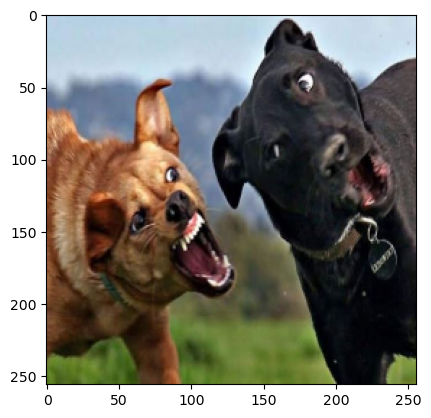

In [79]:
raw_image = cv2.imread('image.jpg')
raw_image = cv2.resize(raw_image, (256, 256))
image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

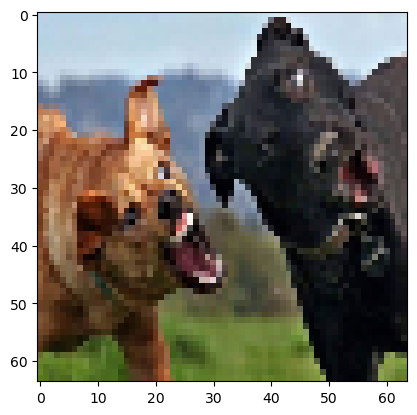

In [80]:
down_sample_image = cv2.resize(image, (64, 64))
plt.imshow(down_sample_image)

23.917262159847013
[23.82976361998437, 23.84360428327622, 24.083058982141047]


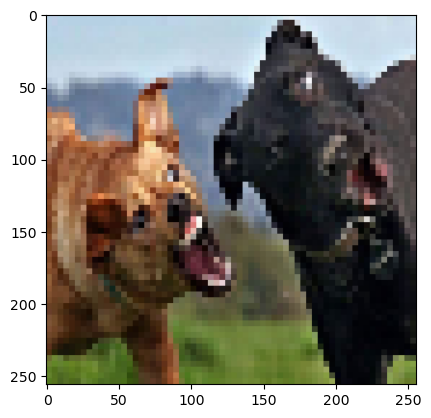

In [81]:
nn_image = nearest_neighbor(down_sample_image)
print(psnr1(image, nn_image))
print(psnr2(image, nn_image))
plt.imshow(nn_image)

31.441867237239094
[31.29410848995837, 31.43004572516937, 31.607110059504965]


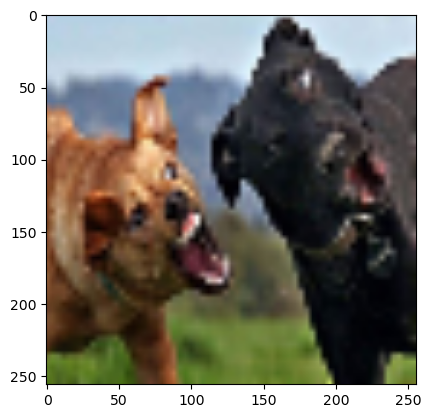

In [82]:
bilinear_image = bilinear(down_sample_image)
print(psnr1(image, bilinear_image))
print(psnr2(image, bilinear_image))
plt.imshow(bilinear_image)

31.045621574143965
[30.90115700837684, 31.006992307278235, 31.235404245077504]


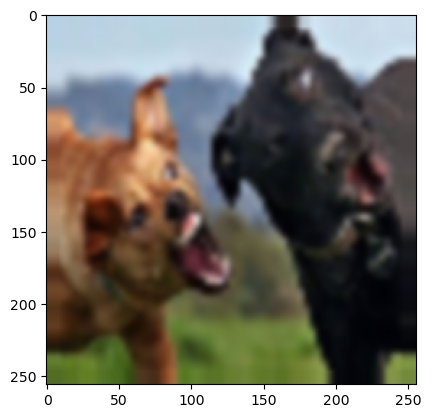

In [83]:
bicubic_image = bicubic(down_sample_image)
print(psnr1(image, bicubic_image))
print(psnr2(image, bicubic_image))
plt.imshow(bicubic_image)